##Phase 1: Base Line Model Training (simCSE)##

# 1. Installing Dependencies

In [1]:
# !pip install transformers torch scipy scikit-learn pandas tqdm wget datasets evaluate

# 2. Importing Model & Dataset

In [2]:
import torch
import numpy

from transformers import AutoTokenizer, AutoModel

# TODO: use princeton-nlp/unsup-simcse-bert-large-uncased for actual training
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")
model = AutoModel.from_pretrained("princeton-nlp/unsup-simcse-roberta-base").to("cuda")

## Import dataset
from datasets import load_dataset

dataset = load_dataset("brando/small-c4-dataset")
print(len(dataset))

# Some tokenizing function, not sure why.
def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

3


## 2.2. Generating Smaller training datasets

(used for time reduction while debugging)

In [3]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(5000))
# small_eval_dataset = tokenized_datasets["test"].shuffle(seed=47).select(range(1000))

eval_dataset = load_dataset("mteb/sts12-sts", split='test')

# 3. Training with PyTorch Trainer

## 3.1. Training hyperparameters

In [4]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer", learning_rate=3e-5, per_device_train_batch_size=8)
training_args.set_evaluate(strategy="steps", steps=100)
training_args.eval_delay = 0

## 3.2. Evaluating using Huggingface evaluation function

In [5]:
stsb = load_dataset("PhilipMay/stsb_multi_mt", "en", split="train")

In [18]:
similar_stsb = stsb.filter(lambda x: x["similarity_score"] > 4)

Filter:   0%|          | 0/5749 [00:00<?, ? examples/s]

In [27]:
import torch.nn.functional as F
def get_embedding(model, tokenizer, input_text, batch_size=32):
    model.eval()

    inputs = tokenizer(input_text, padding='max_length', max_length=128, return_tensors="pt").to("cuda")
    input_tokens, input_masks = inputs['input_ids'], inputs['attention_mask']

    embeddings = []
    with torch.no_grad():
        for i in range(0, len(input_tokens), batch_size):
            embedding = model(
                input_tokens[i : i + batch_size],
                attention_mask=input_masks[i : i + batch_size],
            ).pooler_output
            embedding = torch.nn.functional.normalize(embedding)
            embeddings.append(embedding)
    return torch.vstack(embeddings)


def get_alignment_loss(model, tokenizer, similar_stsb):
    model.eval()

    sentences_1 = similar_stsb["sentence1"]
    sentences_2 = similar_stsb["sentence2"]

    embeddings_1 = get_embedding(model, tokenizer, sentences_1)
    embeddings_2 = get_embedding(model, tokenizer, sentences_2)

    # return (embeddings_1 - embeddings_2).norm(dim=1).mean().item()
    return (embeddings_1 - embeddings_2).norm(p=2, dim=1).pow(2).mean().item()


def get_uniform_loss(model, tokenizer, stsb):
    model.eval()

    sentences = stsb["sentence1"]
    embeddings = get_embedding(model, tokenizer, sentences)

    distance_matrix = torch.pdist(embeddings, p=2) ** 2
    exp_kernel = torch.exp(-2 * distance_matrix)
    uniform_loss = torch.log(exp_kernel.mean())

    return uniform_loss.item()

alignment_loss = get_alignment_loss(model, tokenizer, similar_stsb)
uniform_loss = get_uniform_loss(model, tokenizer, stsb)
print(alignment_loss, uniform_loss)

0.28359267115592957 -3.6766607761383057


In [25]:
alignment_loss

0.4995114803314209

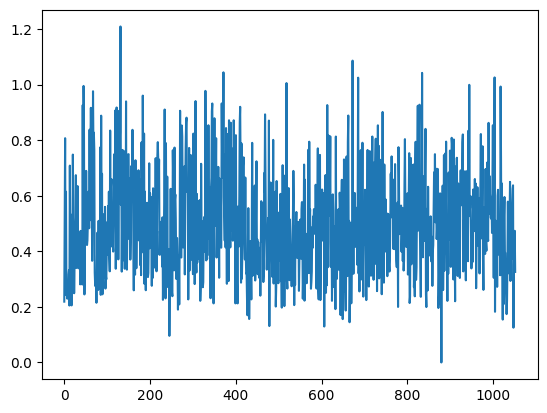

In [20]:
from matplotlib import pyplot as plt

plt.plot(alignment_loss.cpu().numpy())

In [ ]:
input_texts = [
    "Hello, my dog is cute",
    "no, you are a bad person"
]

inputs = tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True).input_ids.to(model.device)
temperature = 0.05

model.train()
# model.eval()
o1 = model(input_ids=inputs, use_cache=False).pooler_output
o2 = model(input_ids=inputs, use_cache=False).pooler_output

## torch.cosine_similarity(ouput 1, output 2) ==> n x m matri,
# i,j's item is is ouput 1 item i vs ouput 2 item j
output1 = o1 / torch.linalg.norm(o1, dim=1, keepdim=True)
output2 = o2 / torch.linalg.norm(o2, dim=1, keepdim=True)

#   print(output1, output2)
M = output1 @ (output2.T)
M /= temperature
print(M)
# # Compute log softmax along the rows
log_softmax_M = torch.log_softmax(M, dim=1)
print(log_softmax_M)

# # Extract the diagonal elements of the log softmax matrix
diag_log_softmax = torch.diagonal(log_softmax_M)
# # Compute the loss as the negative sum of diagonal elements
loss = -diag_log_softmax.sum()
loss

In [ ]:
import numpy as np
from transformers import TrainingArguments, Trainer
from tqdm import tqdm
from scipy.stats import spearmanr

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

# cosine_similarity = torch.cosine_similarity()

class MyTrainer(Trainer):

    def compute_loss(
        self,
        model,
        inputs,
        return_outputs=False,
        num_items_in_batch=1,
        temperature=0.05,
    ):
        self.model.train()
        # self.model.eval()

        o1 = self.model(**inputs, use_cache=False).pooler_output
        o2 = self.model(**inputs, use_cache=False).pooler_output

        ## torch.cosine_similarity(ouput 1, output 2) ==> n x m matri,
        # i,j's item is is ouput 1 item i vs ouput 2 item j
        output1 = o1 / torch.linalg.norm(o1, dim=1, keepdim=True)
        output2 = o2 / torch.linalg.norm(o2, dim=1, keepdim=True)

        #   print(output1, output2)
        M = output1 @ (output2.T)
        M /= temperature
        #   print(M)
        # print(M.shape)
        # Compute log softmax along the rows
        log_softmax_M = torch.log_softmax(M, dim=1)

        # Extract the diagonal elements of the log softmax matrix
        diag_log_softmax = torch.diagonal(log_softmax_M)
        # Compute the loss as the negative sum of diagonal elements
        loss = -diag_log_softmax.mean()
        print(loss)
        return loss

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        """
      Evaluate model performance on STS benchmark using the "all" setting

      Args:
          model: The transformer model to evaluate
          version (int): STS version (12-16)
          batch_size (int): Batch size for processing
      Returns:
          tuple: (overall correlation percentage, dict of domain-wise correlations)
      """
        eval_dataset = self.eval_dataset
        print("THE EVAL DATASET IS,", eval_dataset)

        # Get unique domains/categories if available
        domains = eval_dataset['genre'] if 'genre' in eval_dataset.features else ['all']
        domain_results = {}

        for domain in domains:
            if domain == 'all':
                domain_data = eval_dataset
            else:
                domain_data = eval_dataset.filter(lambda x: x['genre'] == domain)

            sent1 = domain_data['sentence1']
            sent2 = domain_data['sentence2']
            scores = np.array(domain_data['score'])

            # Normalize scores to 0-5 range if needed
            if scores.max() <= 1:
                scores *= 5

            # Generate embeddings
            print(f"Processing domain: {domain}")

            batch_size=32
            embeddings1 = self.get_embeddings(sent1)
            embeddings2 = self.get_embeddings(sent2)

            # Calculate similarities
            predicted_scores = self.cosine_similarity(embeddings1, embeddings2)

            # Calculate Spearman correlation
            correlation, _ = spearmanr(scores, predicted_scores)
            domain_results[domain] = correlation * 100

        # Calculate overall correlation (average across domains)
        overall_correlation = np.mean(list(domain_results.values()))

        # Print detailed results
        print("\nResults by domain:")
        for domain, score in domain_results.items():
            print(f"{domain}: {score:.2f}%")
        version=12
        print(f"\nOverall STS-{version} Spearman correlation: {overall_correlation:.2f}%")

        results = {
          'all': overall_correlation,
          'domain': domain_results
      }

        return results

    def get_embeddings(self, sentences, batch_size=32):
        """
      Generate embeddings for a list of sentences using the model
      """
        self.model.eval()
        embeddings = []
        device = 'cuda'

        with torch.no_grad():
            for i in tqdm(range(0, len(sentences), batch_size), desc="Generating embeddings"):
                batch = sentences[i:min(i + batch_size, len(sentences))]

                encoded = tokenizer(batch, padding=True, truncation=True,
                                max_length=128, return_tensors='pt')

                input_ids = encoded['input_ids'].to(device)
                attention_mask = encoded['attention_mask'].to(device)

                outputs = self.model(
                    input_ids=input_ids, attention_mask=attention_mask
                ).pooler_output

                embeddings.append(outputs)

        return np.vstack(embeddings)

    def cosine_similarity(self, embeddings1, embeddings2):
        """
      Calculate cosine similarity between two sets of embeddings
      """
        norm1 = np.linalg.norm(embeddings1, axis=1)
        norm2 = np.linalg.norm(embeddings2, axis=1)
        return np.sum(embeddings1 * embeddings2, axis=1) / (norm1 * norm2)


trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=eval_dataset
)

## 3.3. Fine tune the model

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
trainer.train()

## Prep work. Evaluation function

input: model

output: its performance against the dataset

In [ ]:
import torch
from datasets import load_dataset
from scipy.stats import spearmanr
import numpy as np
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import pandas as pd

# Map STS versions to their dataset names
# dataset_name = f"mteb/sts{version}-sts"

# print(f"Loading STS-{version} dataset...")
# dataset = load_dataset(dataset_name)['test']


To run this code block, just run the pip install block at the very beginning, and run this block!

In [ ]:
import torch
from datasets import load_dataset
from scipy.stats import spearmanr
import numpy as np
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import pandas as pd

# Map STS versions to their dataset names
# dataset_name = f"mteb/sts{version}-sts"

# print(f"Loading STS-{version} dataset...")
# dataset = load_dataset(dataset_name)['test']


def evaluate(dataset):
    """
    Evaluate model performance on STS benchmark using the "all" setting

    Args:
        model: The transformer model to evaluate
        version (int): STS version (12-16)
        batch_size (int): Batch size for processing
    Returns:
        tuple: (overall correlation percentage, dict of domain-wise correlations)
    """

    # Get unique domains/categories if available
    domains = dataset['genre'] if 'genre' in dataset.features else ['all']
    domain_results = {}

    for domain in domains:
        if domain == 'all':
            domain_data = dataset
        else:
            domain_data = dataset.filter(lambda x: x['genre'] == domain)

        sent1 = domain_data['sentence1']
        sent2 = domain_data['sentence2']
        scores = np.array(domain_data['score'])

        # Normalize scores to 0-5 range if needed
        if scores.max() <= 1:
            scores *= 5

        # Generate embeddings
        print(f"Processing domain: {domain}")
        embeddings1 = get_embeddings(model, tokenizer, sent1, batch_size)
        embeddings2 = get_embeddings(model, tokenizer, sent2, batch_size)

        # Calculate similarities
        predicted_scores = cosine_similarity(embeddings1, embeddings2)

        # Calculate Spearman correlation
        correlation, _ = spearmanr(scores, predicted_scores)
        domain_results[domain] = correlation * 100

    # Calculate overall correlation (average across domains)
    overall_correlation = np.mean(list(domain_results.values()))

    # Print detailed results
    print("\nResults by domain:")
    for domain, score in domain_results.items():
        print(f"{domain}: {score:.2f}%")
    print(f"\nOverall STS-{version} Spearman correlation: {overall_correlation:.2f}%")

    return overall_correlation, domain_results

def get_embeddings(model, tokenizer, sentences, batch_size=32):
    """
    Generate embeddings for a list of sentences using the model
    """
    model.eval()
    embeddings = []
    device = next(model.parameters()).device

    with torch.no_grad():
        for i in tqdm(range(0, len(sentences), batch_size), desc="Generating embeddings"):
            batch = sentences[i:min(i + batch_size, len(sentences))]

            encoded = tokenizer(batch, padding=True, truncation=True,
                              max_length=128, return_tensors='pt')

            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # For SimCSE models, we use the pooler output directly
            if hasattr(outputs, 'pooler_output'):
                batch_embeddings = outputs.pooler_output
            else:
                # Fallback to mean pooling
                mask = attention_mask.unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
                masked_embeddings = outputs.last_hidden_state * mask
                sum_embeddings = torch.sum(masked_embeddings, dim=1)
                sum_mask = torch.clamp(torch.sum(mask, dim=1), min=1e-9)
                batch_embeddings = sum_embeddings / sum_mask

            embeddings.append(batch_embeddings.cpu().numpy())

    return np.vstack(embeddings)

def cosine_similarity(embeddings1, embeddings2):
    """
    Calculate cosine similarity between two sets of embeddings
    """
    norm1 = np.linalg.norm(embeddings1, axis=1)
    norm2 = np.linalg.norm(embeddings2, axis=1)
    return np.sum(embeddings1 * embeddings2, axis=1) / (norm1 * norm2)

# Example usage
if __name__ == "__main__":
    # Load SimCSE model
    model_name = "princeton-nlp/unsup-simcse-roberta-base"
    model = AutoModel.from_pretrained(model_name)

    # Evaluate all STS versions
    results = {}
    versions = [12, 13, 14, 15, 16]

    for version in versions:
        overall_score, domain_scores = evaluate(model, version=version)
        results[f'STS-{version}'] = {
            'overall': overall_score,
            'domains': domain_scores
        }


In [ ]:
import torch


output1 = model()

N = 3

# Example: NxN matrix M
# M = torch.randn(N, N)  # Replace N with your desired dimension
M = torch.tensor([
    [100, -100, -100],
    [-100, 100, -100],
    [-100, -100, 1]
], dtype=torch.float32)

# replace M with the actual similarity matrix

# Compute log softmax along the rows
log_softmax_M = torch.log_softmax(M, dim=1)

# Extract the diagonal elements of the log softmax matrix
diag_log_softmax = torch.diagonal(log_softmax_M)
# Compute the loss as the negative sum of diagonal elements
loss = -diag_log_softmax.sum()

print("Loss:", loss.item())